In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

In [3]:
df = pd.read_csv("/content/drive/MyDrive/RESUME_SEG/New_Dataset.txt")


In [4]:
df

Text
0      ﻿________________\r\n\r\nEDUCATION\r\nOMBA - E...
1      ﻿________________\r\n\r\nHOWARD GERRARD\r\nAcc...
2      ﻿________________\r\n\r\nKevin Frank\r\nSENIOR...
3      ﻿________________\r\n\r\nPlace of birth\r\nNat...
4      ﻿________________\r\n\r\nStephen Greet, CPA\r\...
...                                                  ...
13384  ﻿________________\r\n\r\nJESSICA CLAIRE\r\nMon...
13385  ﻿________________\r\n\r\nJESSICA CLAIRE\r\nMon...
13386  ﻿________________\r\n\r\nSUMMARY\r\nJessica Cl...
13387  ﻿________________\r\n\r\nJESSICA CLAIRE\r\nMon...
13388  ﻿________________\r\n\r\nWEBSITES, PORTFOLIOS,...

[13389 rows x 1 columns]

In [5]:
df.shape

(13389, 1)

In [6]:
print(f"Columns: {df.columns.tolist()}")


Columns: ['Text']


In [7]:
print(df.head())


                                                Text
0  ﻿________________\r\n\r\nEDUCATION\r\nOMBA - E...
1  ﻿________________\r\n\r\nHOWARD GERRARD\r\nAcc...
2  ﻿________________\r\n\r\nKevin Frank\r\nSENIOR...
3  ﻿________________\r\n\r\nPlace of birth\r\nNat...
4  ﻿________________\r\n\r\nStephen Greet, CPA\r\...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13389 entries, 0 to 13388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    13389 non-null  object
dtypes: object(1)
memory usage: 104.7+ KB


In [9]:
def clean_resume_text(text):
    """
    Clean resume text by removing special characters, extra spaces, and standardizing
    """
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces
    text = text.strip()

    return text

In [10]:
resume_column = None
for col in df.columns:
    if 'resume' in col.lower() or 'text' in col.lower():
        resume_column = col
        break

if resume_column is None:
    # If no obvious column found, use the first text column
    resume_column = df.columns[0]

print(f"Using column '{resume_column}' as resume text")

# Clean the resume text
df['cleaned_resume'] = df[resume_column].apply(clean_resume_text)

# Remove empty resumes
df = df[df['cleaned_resume'].str.len() > 0]

print(f"Dataset shape after cleaning: {df.shape}")
print(f"Sample cleaned text:\n{df['cleaned_resume'].iloc[0][:200]}...")

Using column 'Text' as resume text
Dataset shape after cleaning: (13389, 2)
Sample cleaned text:
education omba executive leadership university of texas o bachelor of science in accounting richland college training certifications certified management accountant cma certified financial modeling an...


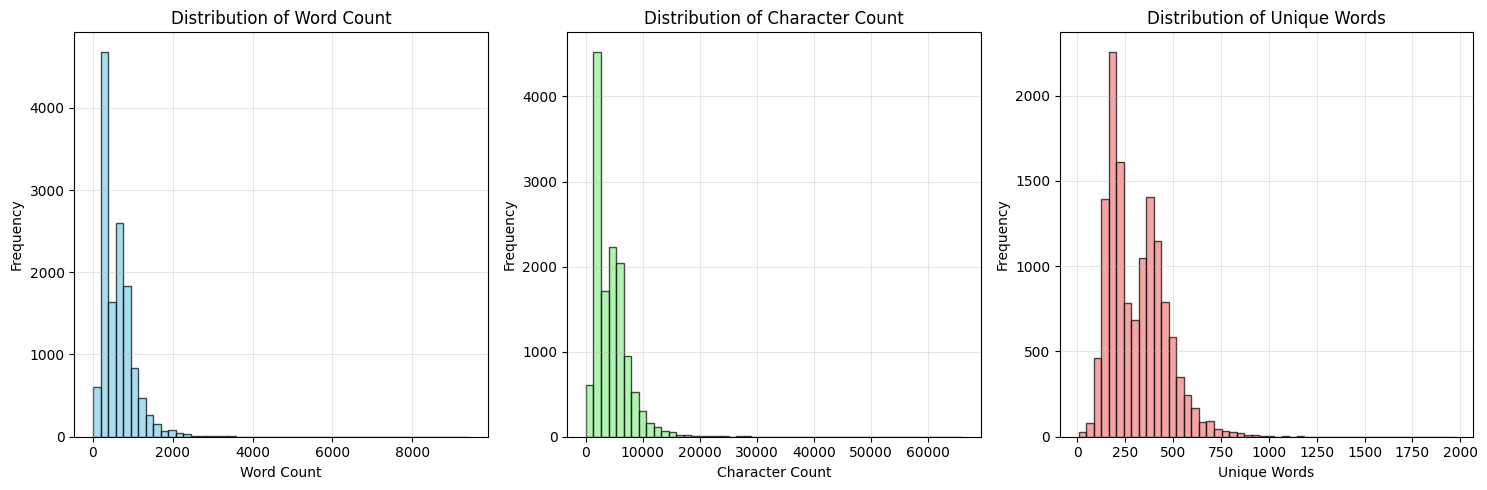

Text Statistics:
Average word count: 617.19
Average character count: 4447.88
Average unique words: 311.14


In [11]:
df['word_count'] = df['cleaned_resume'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_resume'].apply(len)
df['unique_words'] = df['cleaned_resume'].apply(lambda x: len(set(x.split())))

# Plot word count distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['word_count'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(df['char_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribution of Character Count')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(df['unique_words'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Unique Words')
plt.xlabel('Unique Words')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display statistics
print("Text Statistics:")
print(f"Average word count: {df['word_count'].mean():.2f}")
print(f"Average character count: {df['char_count'].mean():.2f}")
print(f"Average unique words: {df['unique_words'].mean():.2f}")


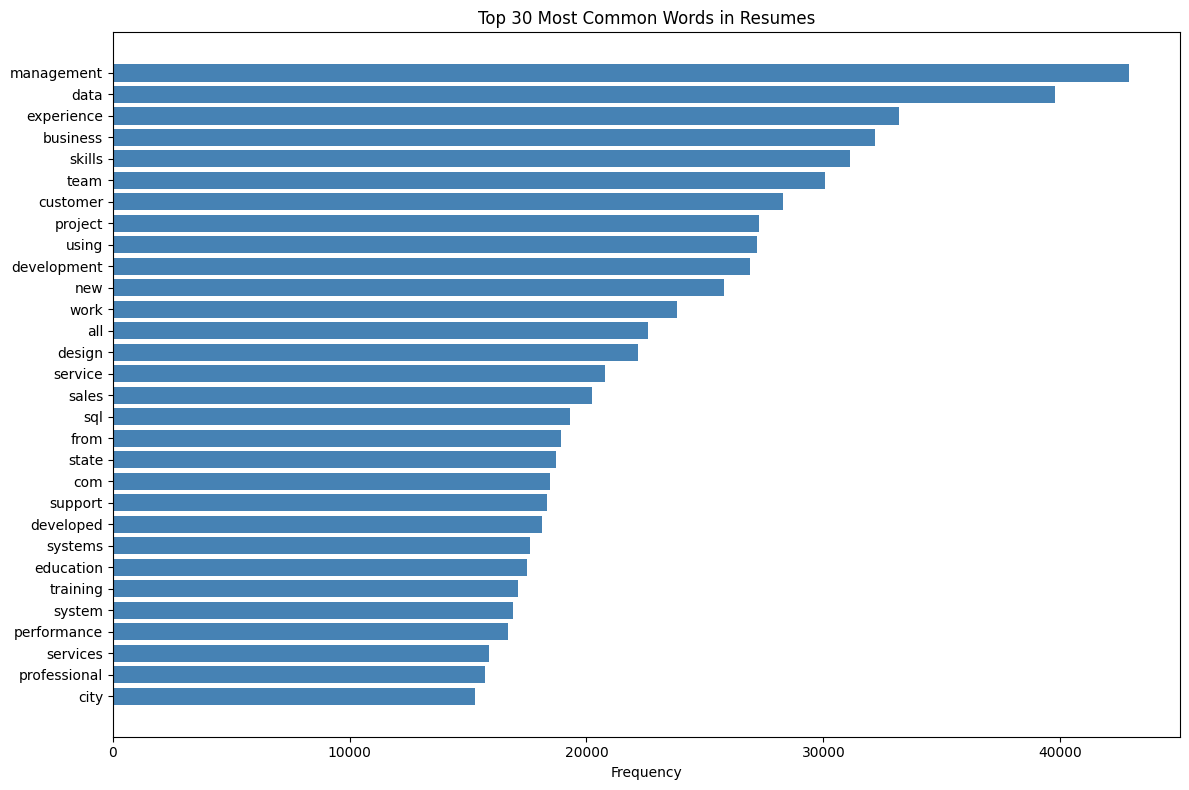

In [12]:
# Get all words from all resumes
all_words = ' '.join(df['cleaned_resume']).split()
word_freq = Counter(all_words)

# Get most common words (excluding very common stop words)
common_stop_words = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'must', 'shall', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their'}

filtered_words = {word: count for word, count in word_freq.items() if word not in common_stop_words and len(word) > 2}
most_common = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)[:30]

# Plot most common words
plt.figure(figsize=(12, 8))
words, counts = zip(*most_common)
plt.barh(range(len(words)), counts, color='steelblue')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Top 30 Most Common Words in Resumes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,  # Limit features for computational efficiency
    min_df=5,           # Ignore terms that appear in less than 5 documents
    max_df=0.8,         # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2)  # Use both unigrams and bigrams
)

# Fit and transform the resume text
print("Vectorizing resume text...")
X = vectorizer.fit_transform(df['cleaned_resume'])

print(f"TF-IDF matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

# Get feature names
feature_names = vectorizer.get_feature_names_out()
print(f"Sample features: {feature_names[:10]}")

Vectorizing resume text...
TF-IDF matrix shape: (13389, 5000)
Number of features: 5000
Sample features: ['ab' 'ab initio' 'abap' 'abc' 'abc corporation' 'abilities' 'ability'
 'ability work' 'able' 'able work']


Testing different number of clusters...
Testing k=2...
Testing k=3...
Testing k=4...
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...
Testing k=11...
Testing k=12...
Testing k=13...
Testing k=14...
Testing k=15...


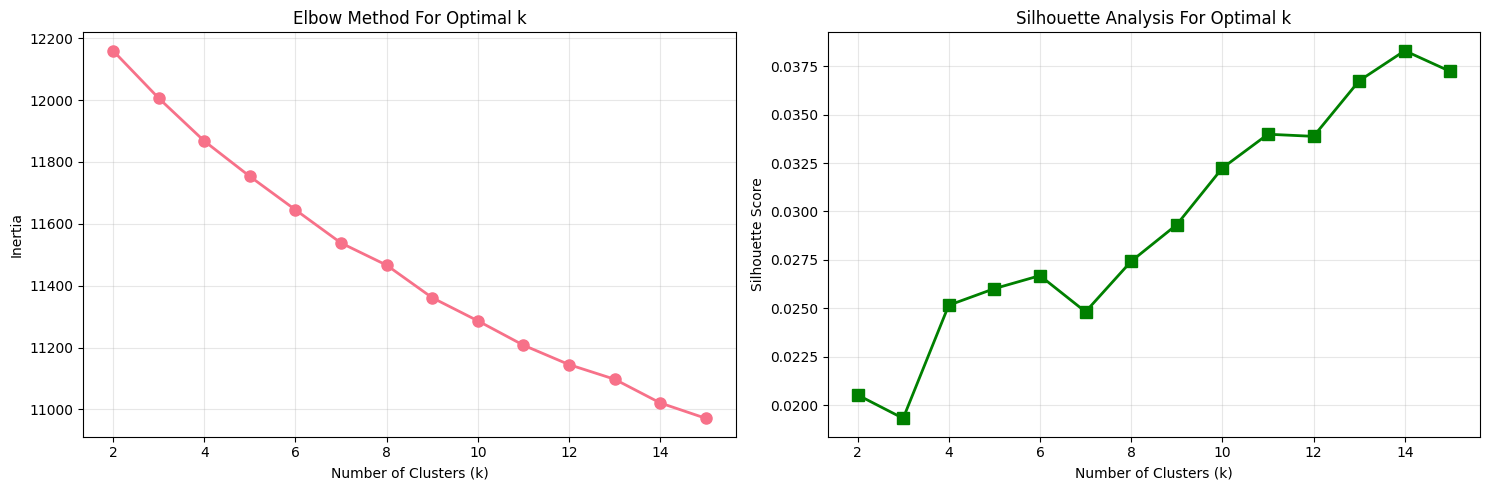

Optimal number of clusters based on silhouette score: 14
Best silhouette score: 0.0383


In [14]:
# Test different number of clusters
k_range = range(2, 16)
inertias = []
silhouette_scores = []

print("Testing different number of clusters...")
for k in k_range:
    print(f"Testing k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot elbow method and silhouette analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
plt.title('Silhouette Analysis For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")

In [15]:
# Apply K-Means with optimal number of clusters
print(f"Applying K-Means clustering with k={optimal_k}...")
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X)

# Add cluster labels to dataframe
df['cluster'] = cluster_labels

print(f"Clustering completed!")
print(f"Cluster distribution:")
print(df['cluster'].value_counts().sort_index())

Applying K-Means clustering with k=14...
Clustering completed!
Cluster distribution:
cluster
0     1845
1      898
2     1475
3     1021
4     2787
5      536
6      723
7      593
8      646
9      303
10     788
11     456
12     744
13     574
Name: count, dtype: int64


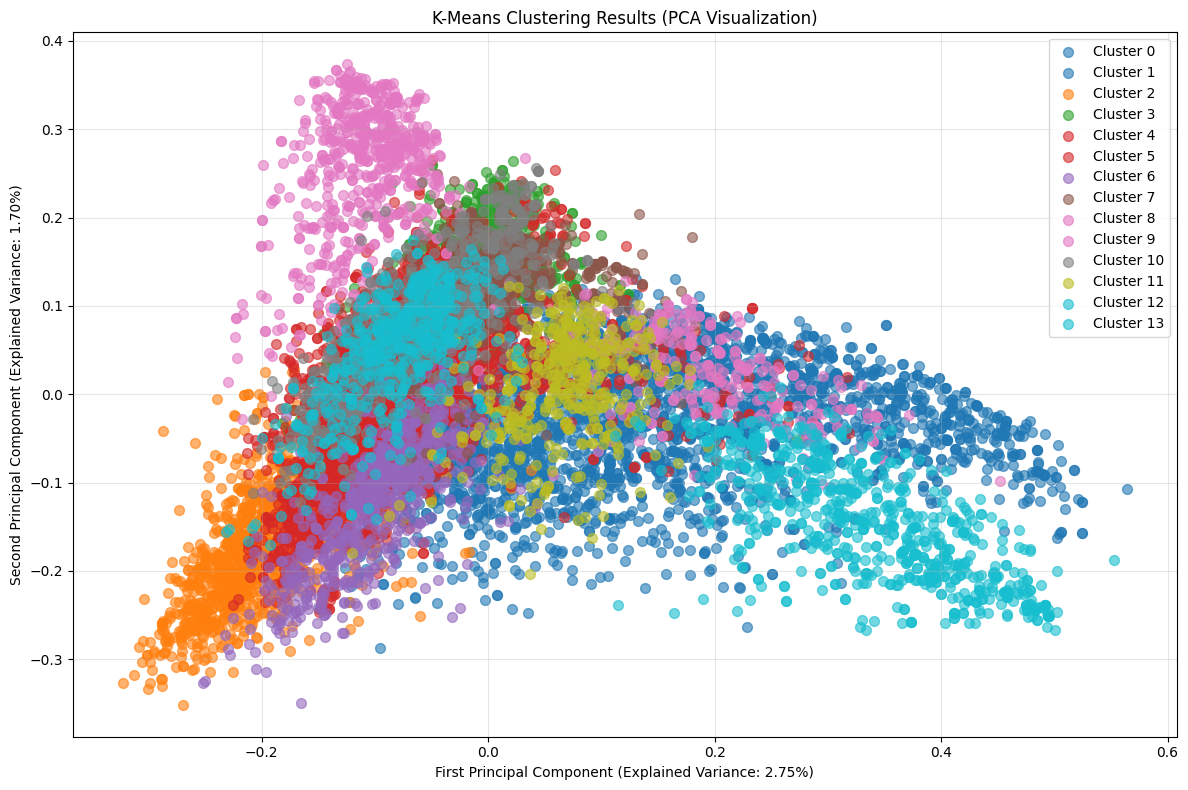

PCA Explained Variance Ratio: [0.02747864 0.01696343]
Total Explained Variance: 4.44%


In [16]:
# Apply PCA for 2D visualization

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# Plot clusters in 2D space
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    cluster_points = X_pca[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=50)

plt.title('K-Means Clustering Results (PCA Visualization)')
plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

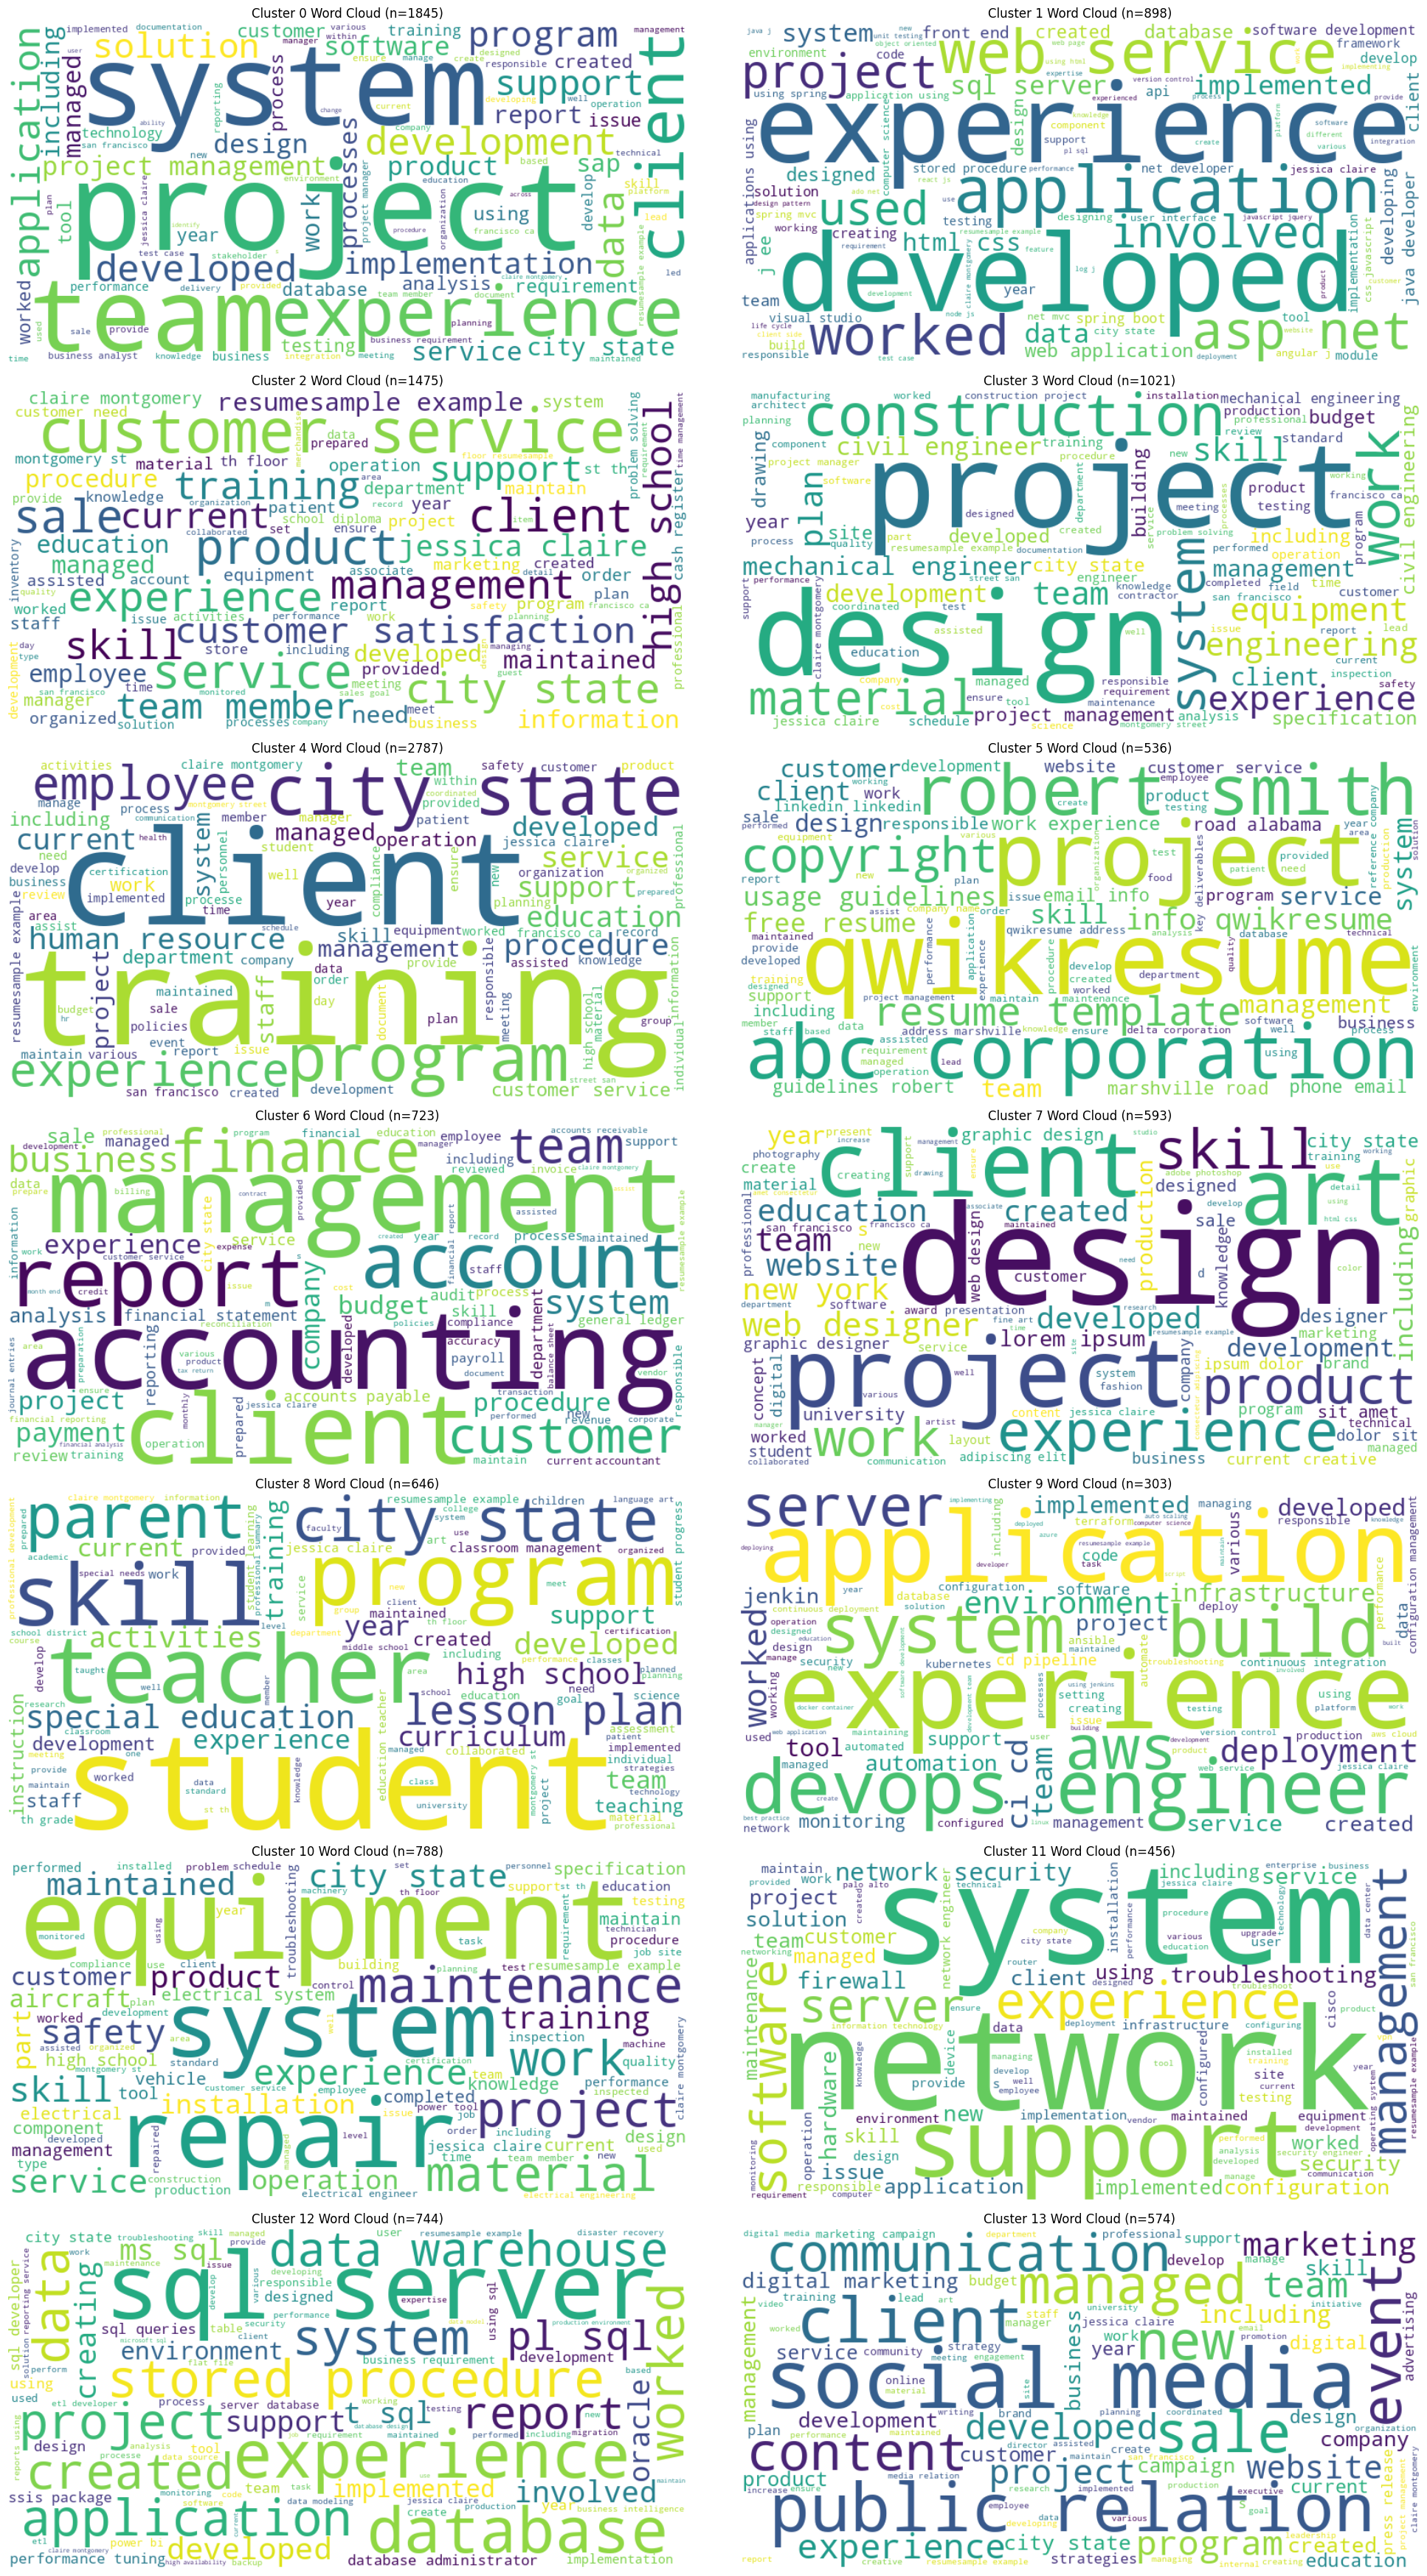

In [17]:
# Create word clouds for each cluster
plt.figure(figsize=(20, 5 * (optimal_k // 2 + 1)))

for i in range(optimal_k):
    cluster_text = ' '.join(df[df['cluster'] == i]['cleaned_resume'])

    if len(cluster_text) > 0:
        wordcloud = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=100,
                             colormap='viridis').generate(cluster_text)

        plt.subplot((optimal_k // 2 + 1), 2, i + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Cluster {i} Word Cloud (n={sum(cluster_labels == i)})')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Get top terms for each cluster
def get_top_terms(cluster_id, n_terms=10):
    """Get top terms for a specific cluster"""
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_tfidf = X[cluster_indices].mean(axis=0).A1
    top_indices = cluster_tfidf.argsort()[-n_terms:][::-1]
    return [(feature_names[i], cluster_tfidf[i]) for i in top_indices]

# Display top terms for each cluster
print("Top Terms by Cluster:")
print("=" * 50)
for i in range(optimal_k):
    top_terms = get_top_terms(i, 15)
    print(f"\nCluster {i} (n={sum(cluster_labels == i)}):")
    for term, score in top_terms:
        print(f"  {term}: {score:.4f}")

Top Terms by Cluster:

Cluster 0 (n=1845):
  business: 0.0849
  data: 0.0762
  project: 0.0756
  sap: 0.0679
  management: 0.0565
  testing: 0.0481
  development: 0.0438
  test: 0.0437
  software: 0.0426
  team: 0.0380
  requirements: 0.0348
  analysis: 0.0347
  process: 0.0344
  analyst: 0.0320
  technical: 0.0305

Cluster 1 (n=898):
  web: 0.1284
  net: 0.1237
  java: 0.1173
  using: 0.1000
  developer: 0.0925
  application: 0.0802
  spring: 0.0785
  sql: 0.0689
  javascript: 0.0622
  html: 0.0618
  css: 0.0601
  development: 0.0581
  applications: 0.0563
  asp: 0.0555
  used: 0.0541

Cluster 2 (n=1475):
  sales: 0.1636
  customer: 0.1372
  customers: 0.0904
  service: 0.0784
  customer service: 0.0552
  store: 0.0514
  merchandise: 0.0472
  team: 0.0420
  products: 0.0410
  management: 0.0396
  product: 0.0395
  items: 0.0394
  cash: 0.0394
  business: 0.0386
  new: 0.0374

Cluster 3 (n=1021):
  construction: 0.1452
  engineering: 0.1006
  mechanical: 0.0978
  civil: 0.0925
  design

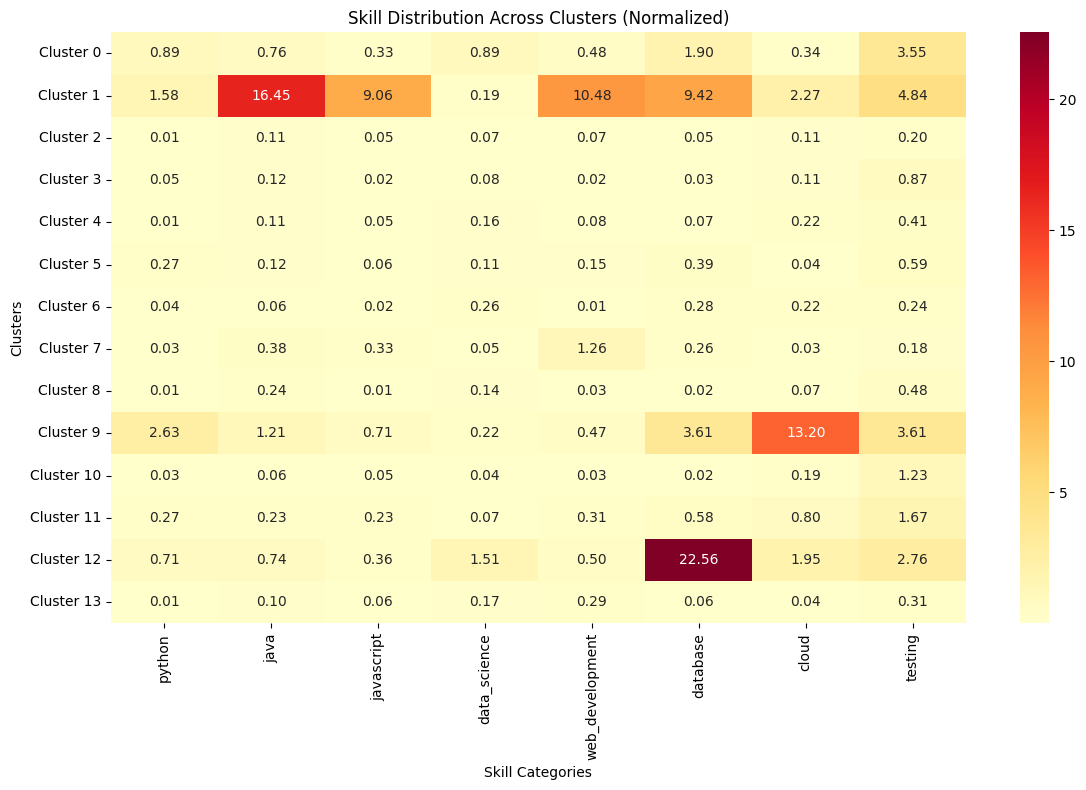

In [19]:
skills = {
    'python': ['python', 'django', 'flask', 'pandas', 'numpy'],
    'java': ['java', 'spring', 'hibernate', 'jsp', 'servlet'],
    'javascript': ['javascript', 'react', 'angular', 'vue', 'node'],
    'data_science': ['machine learning', 'data analysis', 'statistics', 'r language', 'tableau'],
    'web_development': ['html', 'css', 'bootstrap', 'jquery', 'php'],
    'database': ['sql', 'mysql', 'postgresql', 'mongodb', 'oracle'],
    'cloud': ['aws', 'azure', 'gcp', 'docker', 'kubernetes'],
    'testing': ['testing', 'selenium', 'junit', 'automation', 'qa']
}

# Create skill matrix
skill_matrix = pd.DataFrame(index=range(optimal_k), columns=skills.keys())

for skill_category, skill_terms in skills.items():
    for cluster_id in range(optimal_k):
        cluster_text = ' '.join(df[df['cluster'] == cluster_id]['cleaned_resume'])
        skill_count = sum(cluster_text.count(term) for term in skill_terms)
        skill_matrix.loc[cluster_id, skill_category] = skill_count

# Convert to numeric and normalize by cluster size
skill_matrix = skill_matrix.astype(float)
cluster_sizes = df['cluster'].value_counts().sort_index()

for cluster_id in range(optimal_k):
    skill_matrix.loc[cluster_id] = skill_matrix.loc[cluster_id] / cluster_sizes[cluster_id]

# Plot skill analysis
plt.figure(figsize=(12, 8))
sns.heatmap(skill_matrix, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=skills.keys(), yticklabels=[f'Cluster {i}' for i in range(optimal_k)])
plt.title('Skill Distribution Across Clusters (Normalized)')
plt.xlabel('Skill Categories')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

Cluster Statistics:
        word_count                    char_count                        \
              mean     std  min   max       mean      std   min    max   
cluster                                                                  
0           638.45  453.65   78  4547    4597.13  3277.72   557  32496   
1           813.88  577.67   39  4256    5572.51  3916.56   259  29022   
2           707.71  339.72  108  3829    5167.84  2520.23   799  28905   
3           464.28  276.23   21  3162    3381.93  2043.84   169  24492   
4           575.50  387.62    7  6205    4198.58  2847.31    52  43523   
5           302.87   45.00   26   433    2164.58   330.30   181   3054   
6           599.87  370.04   76  3435    4404.58  2716.29   552  23342   
7           389.21  274.07   50  2224    2710.85  1952.58   358  14466   
8           650.20  473.15  101  9421    4778.31  3416.25   712  65876   
9           653.75  407.62  143  2708    4642.49  2933.43  1036  18547   
10          650.71

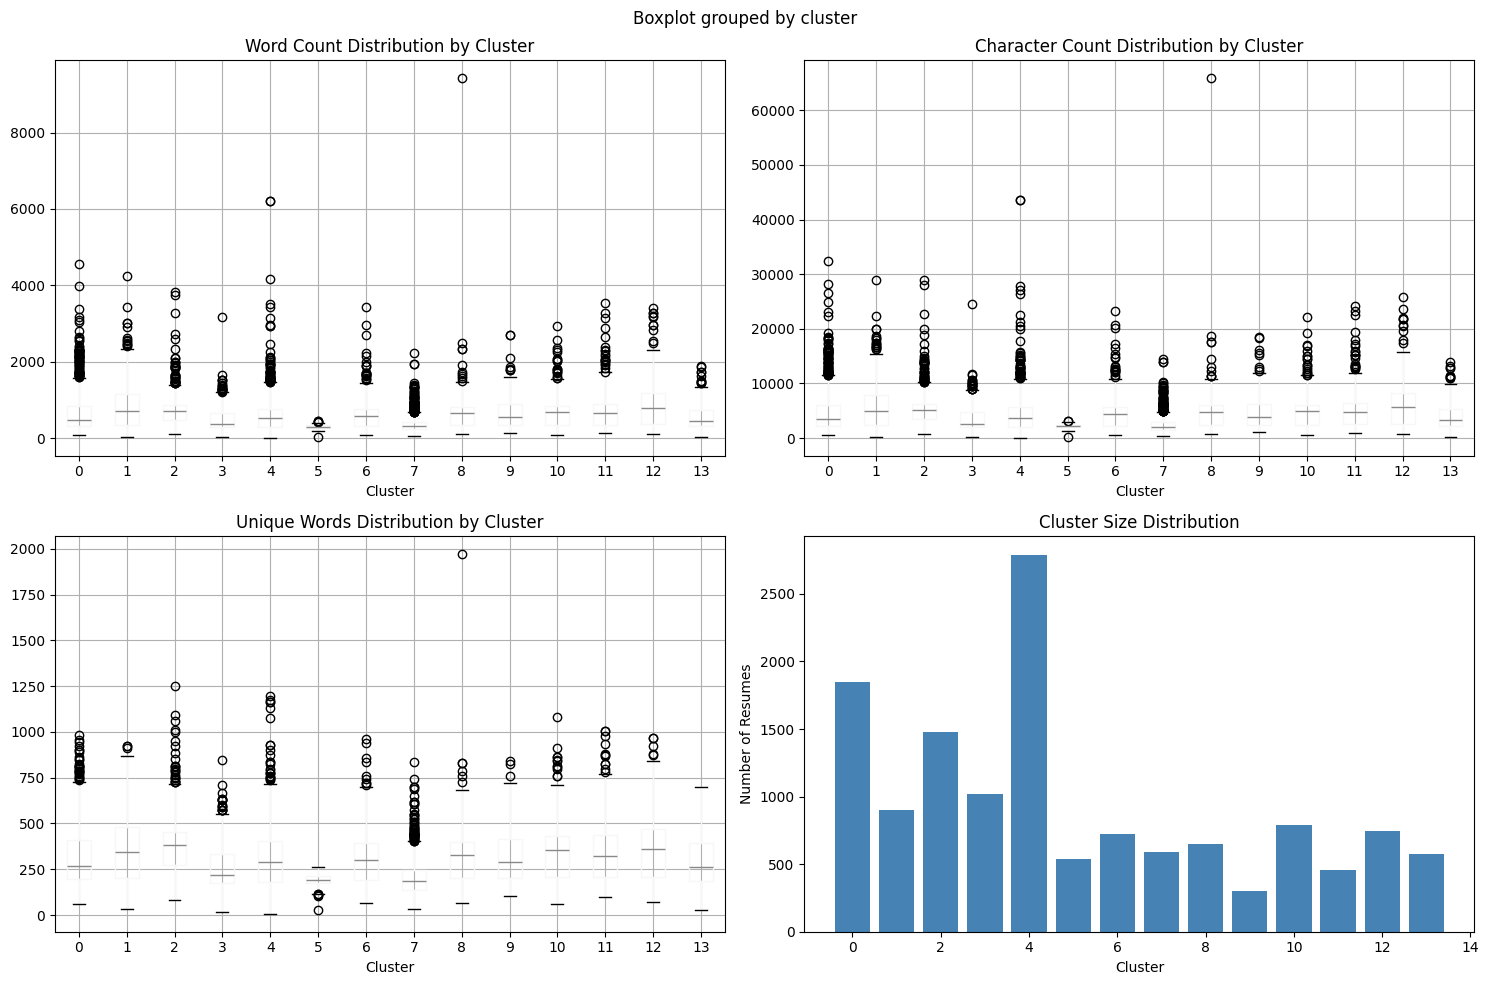

In [20]:
# Analyze cluster characteristics
cluster_stats = df.groupby('cluster').agg({
    'word_count': ['mean', 'std', 'min', 'max'],
    'char_count': ['mean', 'std', 'min', 'max'],
    'unique_words': ['mean', 'std', 'min', 'max']
}).round(2)

print("Cluster Statistics:")
print(cluster_stats)

# Plot cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Word count by cluster
df.boxplot(column='word_count', by='cluster', ax=axes[0, 0])
axes[0, 0].set_title('Word Count Distribution by Cluster')
axes[0, 0].set_xlabel('Cluster')

# Character count by cluster
df.boxplot(column='char_count', by='cluster', ax=axes[0, 1])
axes[0, 1].set_title('Character Count Distribution by Cluster')
axes[0, 1].set_xlabel('Cluster')

# Unique words by cluster
df.boxplot(column='unique_words', by='cluster', ax=axes[1, 0])
axes[1, 0].set_title('Unique Words Distribution by Cluster')
axes[1, 0].set_xlabel('Cluster')

# Cluster size distribution
cluster_sizes = df['cluster'].value_counts().sort_index()
axes[1, 1].bar(cluster_sizes.index, cluster_sizes.values, color='steelblue')
axes[1, 1].set_title('Cluster Size Distribution')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Number of Resumes')

plt.tight_layout()
plt.show()

In [21]:
#Create Prediction Model
import joblib

class ResumeClusterPredictor:
    def __init__(self, vectorizer, kmeans_model, pca_model=None):
        self.vectorizer = vectorizer
        self.kmeans_model = kmeans_model
        self.pca_model = pca_model
        self.cluster_descriptions = {}

    def predict_cluster(self, resume_text):
        """Predict cluster for a new resume"""
        # Clean the text
        cleaned_text = clean_resume_text(resume_text)

        # Vectorize
        text_vector = self.vectorizer.transform([cleaned_text])

        # Predict cluster
        cluster = self.kmeans_model.predict(text_vector)[0]

        # Get probability/confidence
        distances = self.kmeans_model.transform(text_vector)[0]
        confidence = 1 / (1 + distances[cluster])  # Simple confidence metric

        return cluster, confidence

    def add_cluster_description(self, cluster_id, description):
        """Add description for a cluster"""
        self.cluster_descriptions[cluster_id] = description

    def get_cluster_info(self, cluster_id):
        """Get information about a specific cluster"""
        return self.cluster_descriptions.get(cluster_id, f"Cluster {cluster_id}")

# Create the prediction model
predictor = ResumeClusterPredictor(vectorizer, final_kmeans, pca)

# Add cluster descriptions based on analysis
# You can customize these based on your cluster analysis
for i in range(optimal_k):
    predictor.add_cluster_description(i, f"Professional Category {i}")

print("Prediction model created successfully!")

Prediction model created successfully!


In [22]:
# Test with sample resumes
sample_resumes = [
    "Experienced software developer with expertise in Python, Django, and machine learning. Strong background in data analysis and statistical modeling.",
    "Senior Java developer with 5+ years of experience in enterprise applications. Skilled in Spring Boot, Hibernate, and microservices architecture.",
    "Data scientist with expertise in machine learning, statistical analysis, and data visualization. Proficient in Python, R, and SQL.",
    "Web developer specializing in frontend technologies including React, Angular, and Vue.js. Experience with responsive design and user experience."
]

print("Testing prediction model with sample resumes:")
print("=" * 60)

for i, resume in enumerate(sample_resumes):
    cluster, confidence = predictor.predict_cluster(resume)
    print(f"\nSample Resume {i+1}:")
    print(f"Text: {resume[:100]}...")
    print(f"Predicted Cluster: {cluster}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Cluster Info: {predictor.get_cluster_info(cluster)}")

Testing prediction model with sample resumes:

Sample Resume 1:
Text: Experienced software developer with expertise in Python, Django, and machine learning. Strong backgr...
Predicted Cluster: 0
Confidence: 0.4970
Cluster Info: Professional Category 0

Sample Resume 2:
Text: Senior Java developer with 5+ years of experience in enterprise applications. Skilled in Spring Boot...
Predicted Cluster: 1
Confidence: 0.5020
Cluster Info: Professional Category 1

Sample Resume 3:
Text: Data scientist with expertise in machine learning, statistical analysis, and data visualization. Pro...
Predicted Cluster: 0
Confidence: 0.4982
Cluster Info: Professional Category 0

Sample Resume 4:
Text: Web developer specializing in frontend technologies including React, Angular, and Vue.js. Experience...
Predicted Cluster: 1
Confidence: 0.4983
Cluster Info: Professional Category 1


In [25]:
#Save the Model
import os

# Create the directory if it doesn't exist
save_directory = '/content/drive/MyDrive/k_means_model'
os.makedirs(save_directory, exist_ok=True)

# Save all components of the model
model_components = {
    'vectorizer': vectorizer,
    'kmeans_model': final_kmeans,
    'pca_model': pca,
    'predictor': predictor,
    'optimal_k': optimal_k,
    'feature_names': feature_names,
    'cluster_stats': cluster_stats
}

In [26]:
# Save using joblib to the specified directory
model_path = os.path.join(save_directory, 'resume_clustering_model.pkl')
joblib.dump(model_components, model_path)
print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /content/drive/MyDrive/k_means_model/resume_clustering_model.pkl


In [27]:
# Save cluster analysis results
# Convert cluster_stats to JSON-serializable format
cluster_stats_dict = {}
for cluster_id in cluster_stats.index:
    cluster_stats_dict[f'cluster_{cluster_id}'] = {}
    for col in cluster_stats.columns:
        if isinstance(col, tuple):
            # Handle multi-level column names
            col_key = f"{col[0]}_{col[1]}"
        else:
            col_key = str(col)
        cluster_stats_dict[f'cluster_{cluster_id}'][col_key] = float(cluster_stats.loc[cluster_id, col])

In [28]:
# Convert skill_matrix to JSON-serializable format
skill_matrix_dict = {}
for cluster_id in skill_matrix.index:
    skill_matrix_dict[f'cluster_{cluster_id}'] = {}
    for skill in skill_matrix.columns:
        skill_matrix_dict[f'cluster_{cluster_id}'][skill] = float(skill_matrix.loc[cluster_id, skill])

analysis_results = {
    'cluster_distribution': df['cluster'].value_counts().sort_index().to_dict(),
    'silhouette_score': float(max(silhouette_scores)),
    'explained_variance': pca.explained_variance_ratio_.tolist(),
    'skill_matrix': skill_matrix_dict,
    'cluster_stats': cluster_stats_dict
}

import json
analysis_path = os.path.join(save_directory, 'cluster_analysis_results.json')
with open(analysis_path, 'w') as f:
    json.dump(analysis_results, f, indent=2)

print(f"Analysis results saved at: {analysis_path}")

Analysis results saved at: /content/drive/MyDrive/k_means_model/cluster_analysis_results.json


In [29]:
# Also save the processed dataframe with cluster labels
df_path = os.path.join(save_directory, 'clustered_resumes.csv')
df.to_csv(df_path, index=False)
print(f"Clustered dataset saved at: {df_path}")

print(f"\nAll files saved in directory: {save_directory}")
print("Contents:")
print("- resume_clustering_model.pkl (Complete model)")
print("- cluster_analysis_results.json (Analysis results)")
print("- clustered_resumes.csv (Dataset with cluster labels)")

# Cell 17: Model Evaluation and Summary
print("=" * 60)
print("RESUME CLUSTERING MODEL SUMMARY")
print("=" * 60)

print(f"Dataset Size: {len(df)} resumes")
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Best Silhouette Score: {max(silhouette_scores):.4f}")
print(f"TF-IDF Features: {X.shape[1]}")
print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

print("\nCluster Distribution:")
for i in range(optimal_k):
    count = sum(cluster_labels == i)
    percentage = (count / len(df)) * 100
    print(f"Cluster {i}: {count} resumes ({percentage:.1f}%)")

print("\nModel Components Saved:")
print("- TF-IDF Vectorizer")
print("- K-Means Clustering Model")
print("- PCA Transformation")
print("- Resume Cluster Predictor")
print("- Analysis Results")

print("\nTo use the model for prediction:")
print("1. Load the model: model = joblib.load('resume_clustering_model.pkl')")
print("2. Use predictor: cluster, confidence = model['predictor'].predict_cluster(resume_text)")

Clustered dataset saved at: /content/drive/MyDrive/k_means_model/clustered_resumes.csv

All files saved in directory: /content/drive/MyDrive/k_means_model
Contents:
- resume_clustering_model.pkl (Complete model)
- cluster_analysis_results.json (Analysis results)
- clustered_resumes.csv (Dataset with cluster labels)
RESUME CLUSTERING MODEL SUMMARY
Dataset Size: 13389 resumes
Optimal Number of Clusters: 14
Best Silhouette Score: 0.0383
TF-IDF Features: 5000
PCA Explained Variance: 4.44%

Cluster Distribution:
Cluster 0: 1845 resumes (13.8%)
Cluster 1: 898 resumes (6.7%)
Cluster 2: 1475 resumes (11.0%)
Cluster 3: 1021 resumes (7.6%)
Cluster 4: 2787 resumes (20.8%)
Cluster 5: 536 resumes (4.0%)
Cluster 6: 723 resumes (5.4%)
Cluster 7: 593 resumes (4.4%)
Cluster 8: 646 resumes (4.8%)
Cluster 9: 303 resumes (2.3%)
Cluster 10: 788 resumes (5.9%)
Cluster 11: 456 resumes (3.4%)
Cluster 12: 744 resumes (5.6%)
Cluster 13: 574 resumes (4.3%)

Model Components Saved:
- TF-IDF Vectorizer
- K-Means C

In [30]:
# Cell 18: Function to Load and Use the Model
def load_and_use_model(resume_text, model_path='/content/drive/MyDrive/k_means_model/resume_clustering_model.pkl'):
    """
    Load the saved model and predict cluster for new resume
    """
    # Load the model
    model_components = joblib.load(model_path)
    predictor = model_components['predictor']

    # Make prediction
    cluster, confidence = predictor.predict_cluster(resume_text)

    return {
        'cluster': cluster,
        'confidence': confidence,
        'cluster_info': predictor.get_cluster_info(cluster)
    }

In [31]:
# Example usage function
def example_usage():
    """Example of how to use the saved model"""
    new_resume = """
    Senior Software Engineer with 7+ years of experience in full-stack development.
    Expertise in Python, JavaScript, React, and Node.js. Strong background in
    database design and API development. Experience with cloud platforms like AWS.
    """

    try:
        result = load_and_use_model(new_resume)
        print("Prediction Result:")
        print(f"Cluster: {result['cluster']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print(f"Category: {result['cluster_info']}")
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure the model file exists and is properly saved.")

In [32]:
# Additional utility function to load model from Google Drive
def load_model_from_drive(drive_path='/content/drive/MyDrive/k_means_model'):
    """
    Load all model components from Google Drive
    """
    model_path = os.path.join(drive_path, 'resume_clustering_model.pkl')
    analysis_path = os.path.join(drive_path, 'cluster_analysis_results.json')

    if os.path.exists(model_path):
        model_components = joblib.load(model_path)
        print(f"Model loaded successfully from: {model_path}")

        if os.path.exists(analysis_path):
            with open(analysis_path, 'r') as f:
                analysis_results = json.load(f)
            print(f"Analysis results loaded from: {analysis_path}")
            return model_components, analysis_results
        else:
            print("Analysis results file not found.")
            return model_components, None
    else:
        print(f"Model file not found at: {model_path}")
        return None, None

print("Model building and training completed successfully!")
print("You can now use the model to predict resume categories for new resumes.")
print(f"All files saved in: /content/drive/MyDrive/k_means_model/")

Model building and training completed successfully!
You can now use the model to predict resume categories for new resumes.
All files saved in: /content/drive/MyDrive/k_means_model/
